In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Data Processing Pipeline

In [2]:
df = pd.read_excel('~/Desktop/USF_courses/Practicum/data/BrainMets_List_July2020_LF_OS.xlsx')

#### Get patient number
def get_patient(col):
    lst = col.split('-')
    return lst[2]

#### Response_v: use time to death if it is not null else positive follow-up time
def get_response(df):
    if df['Time to death']>0:
        return df['Time to death']
    elif df['Follow-up time']>0:
        return df['Follow-up time']
       
df['patient'] = df['PiCare MetID'].apply(lambda x:get_patient(x))
df['response_v'] = df.apply(lambda x:get_response(x),axis=1)

#### Convert all 1/0 to True/False
def binary(col):
    if col == '1' or col == 1:
        return 'True'
    if col == '0' or col == 0:
        return 'False'
    return col
df['ECM'] = df['ECM'].apply(lambda x:binary(x))
df['Prior_Chemo']=df['Prior_Chemo'].apply(lambda x:binary(x))
df['Prior_Chemo'].unique()

array(['True', 'False', 'Unkn'], dtype=object)

In [3]:
#Drop columns that are all null value
def drop_column(data, col):
    return data.drop(columns=[col])

for col in df.columns:
    if df[col].isnull().sum()==10445:
        print('drop empty column:',col)
        df = drop_column(df,col)
df.shape

drop empty column: Race
drop empty column: GPA
drop empty column: RPA
drop empty column: ECOG
drop empty column: Conformity index
drop empty column: Gradient index
drop empty column: Heterogeneity index
drop empty column: Distance from Ventricle
drop empty column: BRAF_status
drop empty column: CKIT_status
drop empty column: NRAS_status
drop empty column: EFGR_status
drop empty column: ALK_status
drop empty column: HER2-amplified status
drop empty column: Distance_from_ventricle


(10445, 43)

In [4]:
def hash_encode_cols(data, col):
    print("Encoding column ",col)
    data[col] = data[col].apply(hash).astype("int32")
    
def label_encoding_with_NAs(data,col):
    data[col] = data[col].astype('category').cat.as_ordered()
    encoder = data[col].cat.categories
    print("Encoding column ",col)
    # leaving 0 for NAs
    data[col] = data[col].cat.codes + 1

In [5]:
#### Only keep first GK data for one patient
df_keepfirst = df.sort_values(by = 'Date GK').drop_duplicates(subset = ['patient'],keep = 'first')

In [6]:
df_tree= drop_column(df_keepfirst,'Time to death')

In [7]:
df_tree.columns

Index(['PiCare MetID', 'Failure-binary', 'Failure-eventFreeTime',
       'Follow-up time', 'Date GK', 'Age', 'Sex', 'Primary tumor Site',
       'Primary tumor Histology', 'ECM', 'Location', 'Brief location', 'Side',
       'Lateral dimension', 'AP dimension', 'Vertical dimension',
       '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prescribed IDL', 'Target vol in IDL', 'IDL volume',
       'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Salvage_RS', 'Salv_surg', 'Headaches',
       'Seizures', 'Neuro symptoms', 'Prescription Dose', 'Max Dose',
       'Target volume', 'Target vol in IDL.1', 'Maximum Tumor Diameter',
       'patient', 'response_v'],
      dtype='object')

In [8]:
columns_drop = """'PiCare MetID'
'Failure-binary'
'Failure-eventFreeTime'
'Follow-up time'
'Date GK'
'Lateral dimension'
'AP dimension'
'Vertical dimension'
'Prescribed IDL'
'Target vol in IDL'
'IDL volume'
'Vol in 12 Gy line'
'Vol in 10 Gy line'
'Salvage_RS'
'Salv_surg'
'Headaches'
'Seizures'
'Prescription Dose'
'Max Dose'
'Target vol in IDL.1'
'patient'"""

In [9]:
## Drop columns according to the excel spreadsheet
col_lst = columns_drop.split('\n')
print(len(col_lst))
for col in col_lst:
    col=col.strip("'")
    print('drop column:',col)
    df_tree= drop_column(df_tree,col)

21
drop column: PiCare MetID
drop column: Failure-binary
drop column: Failure-eventFreeTime
drop column: Follow-up time
drop column: Date GK
drop column: Lateral dimension
drop column: AP dimension
drop column: Vertical dimension
drop column: Prescribed IDL
drop column: Target vol in IDL
drop column: IDL volume
drop column: Vol in 12 Gy line
drop column: Vol in 10 Gy line
drop column: Salvage_RS
drop column: Salv_surg
drop column: Headaches
drop column: Seizures
drop column: Prescription Dose
drop column: Max Dose
drop column: Target vol in IDL.1
drop column: patient


In [10]:
df_tree.columns

Index(['Age', 'Sex', 'Primary tumor Site', 'Primary tumor Histology', 'ECM',
       'Location', 'Brief location', 'Side', '#Metastases at 1st GK',
       'Time between prim and met diagnosis', 'Prior SRS to same lesion',
       'Prior SRS to other lesion', 'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Neuro symptoms', 'Target volume',
       'Maximum Tumor Diameter', 'response_v'],
      dtype='object')

In [11]:
df_tree = df_tree.dropna(subset = ['response_v','Primary tumor Site','#Metastases at 1st GK'])

In [12]:
df_drop = df_tree[df_tree.columns[~df_tree.isnull().any()]]

In [13]:
df_drop.shape

(1577, 10)

In [14]:
df_drop['Primary tumor Site'].unique()

array(['Breast', 'Melanoma', 'GI', 'Lung', 'Kidney', 'Unknown', 'Other',
       'GYN', 'Sarcoma'], dtype=object)

In [15]:
##create different datasets separated by primary tumor site
dfs = []
for site in df_tree['Primary tumor Site'].unique():
    dff= df_tree[df_tree['Primary tumor Site']==site]
    if (site != 'Unknown') & (site != 'Other'):
        dfs.append((site,dff))

In [16]:
for site, dff in dfs:
    print (site, dff.shape)

Breast (371, 21)
Melanoma (345, 21)
GI (58, 21)
Lung (579, 21)
Kidney (96, 21)
GYN (39, 21)
Sarcoma (22, 21)


In [17]:
def split_target(df, target):
    Y = df[target].values
    X = df.drop(columns=[target])
    return X, Y

def process(df):
    #only keep columns with less than 50 null data
    na_number = df.isnull().sum()
    df = df[df.columns[na_number<50]].dropna()
    df = drop_column(df,'Primary tumor Site')
    #encoding catagorical columns and NA data
    for c,dtype in zip(df.columns,df.dtypes):
        if dtype == 'object' or dtype == 'datetime64[ns]':
            label_encoding_with_NAs(df,c)
    X,y = split_target(df,'response_v')
    return X,y
# X,y = process(dfs[0][1])

# Random Forest

In [69]:
# Random search with CV
def Random_search_cv(X,y):
    #Cross-validation for hyperparameter search
    max_depth = [int(x) for x in np.linspace(5, 20, num = 15)]
    max_features = [x for x in np.linspace(0.1, 0.8, num = 15)]
    min_samples_leaf = [int(x) for x in np.linspace(5, 20, num = 15)]

    random_grid = {'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf}

    rf = RandomForestRegressor(n_estimators=100)

    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = random_grid,
                                   scoring = 'neg_mean_squared_error',
                                   n_iter = 10, 
                                   random_state=42, 
                                   verbose=0, 
                                   n_jobs = -1)

    rf_random.fit(X,y)

    best_score = rf_random.best_score_
    
    #Get the 'best' hyperparameter and fit all the data
    h1 = rf_random.best_params_['min_samples_leaf']
    h2 = rf_random.best_params_['max_features']
    h3 = rf_random.best_params_['max_depth']

    rf_all = RandomForestRegressor(n_jobs = -1, 
                                   n_estimators=100, 
                                   min_samples_leaf=h1,
                                   max_features=h2, 
                                   max_depth=h3, 
                                   verbose=0,
                                   oob_score=True)

    rf_all.fit(X,y)

    # y_hat = rf_all.predict(X)
    # mse = mean_squared_error(y,y_hat)
    return h1,h2,h3,rf_all

In [70]:
def feature_importance_visual(ax,col,fi,t = 'Feature Importance Visualization'):

    ax.bar(col,fi)
#    ax.xticks(fontsize=12)

    ax.set_title(label = t,
                 pad=10,
                size = 20)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [71]:
info = []
for site, data in dfs:
    print(site)
    X,y = process(data)
    if X.shape[0]<20:
        continue
    output = Random_search_cv(X,y)

    info.append((site,output,X,y))

Breast
Encoding column  Sex
Encoding column  Primary tumor Histology
Encoding column  ECM
Encoding column  Location
Encoding column  Side
Encoding column  Prior_EBRT
Encoding column  Prior_RS
Encoding column  Prior_Chemo
Encoding column  Neuro symptoms
Melanoma
Encoding column  Sex
Encoding column  Primary tumor Histology
Encoding column  ECM
Encoding column  Location
Encoding column  Side
Encoding column  Prior_EBRT
Encoding column  Prior_RS
Encoding column  Prior_Chemo
GI
Encoding column  Sex
Encoding column  Primary tumor Histology
Encoding column  ECM
Encoding column  Location
Encoding column  Brief location
Encoding column  Side
Encoding column  Prior_EBRT
Encoding column  Prior_RS
Encoding column  Prior_Chemo
Encoding column  Neuro symptoms
Lung
Encoding column  Sex
Encoding column  Primary tumor Histology
Encoding column  ECM
Encoding column  Location
Encoding column  Side
Encoding column  Prior_EBRT
Encoding column  Prior_RS
Encoding column  Prior_Chemo
Kidney
Encoding column  

#### Breast:
X_shape: 	 (307, 17)
min_samples_leaf 6, max_features 0.2, max_depth 7
Remove "bad feature":
	Sex:  0.0000
	Primary tumor Histology:  0.0000
The out of bag R2 score for model with all features is 	 0.045.
The out of bag R2 score for model removing "bad features" is  	 0.053.

#### Melanoma:
X_shape: 	 (309, 16)
min_samples_leaf 6, max_features 0.2, max_depth 7
Remove "bad feature":
	Primary tumor Histology:  0.0000
The out of bag R2 score for model with all features is 	 0.043.
The out of bag R2 score for model removing "bad features" is  	 0.039.

#### Lung:
X_shape: 	 (502, 15)
min_samples_leaf 8, max_features 0.3, max_depth 12
Remove "bad feature":
	Prior_RS:  0.0000
The out of bag R2 score for model with all features is 	 0.071.
The out of bag R2 score for model removing "bad features" is  	 0.058.

#### Kidney:
X_shape: 	 (74, 17)
min_samples_leaf 8, max_features 0.3, max_depth 12
Remove "bad feature":
	ECM:  0.0000
	Prior SRS to same lesion:  0.0000
	Prior_RS:  0.000

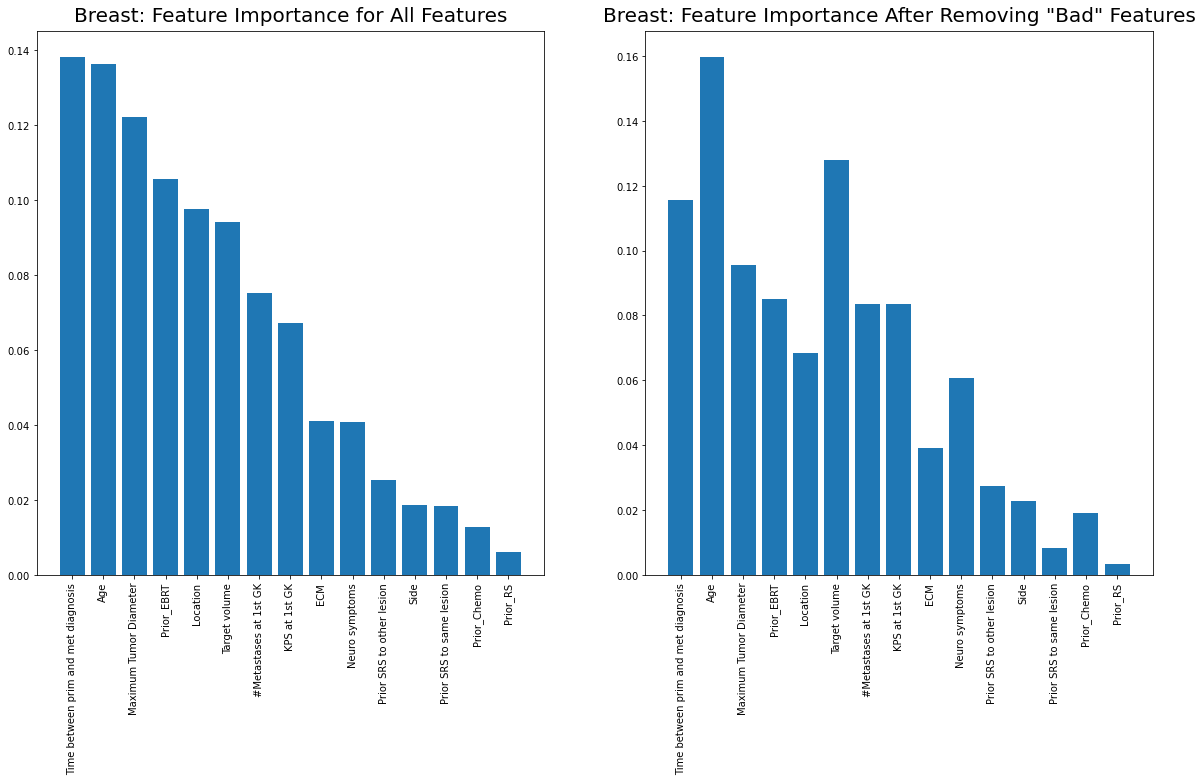

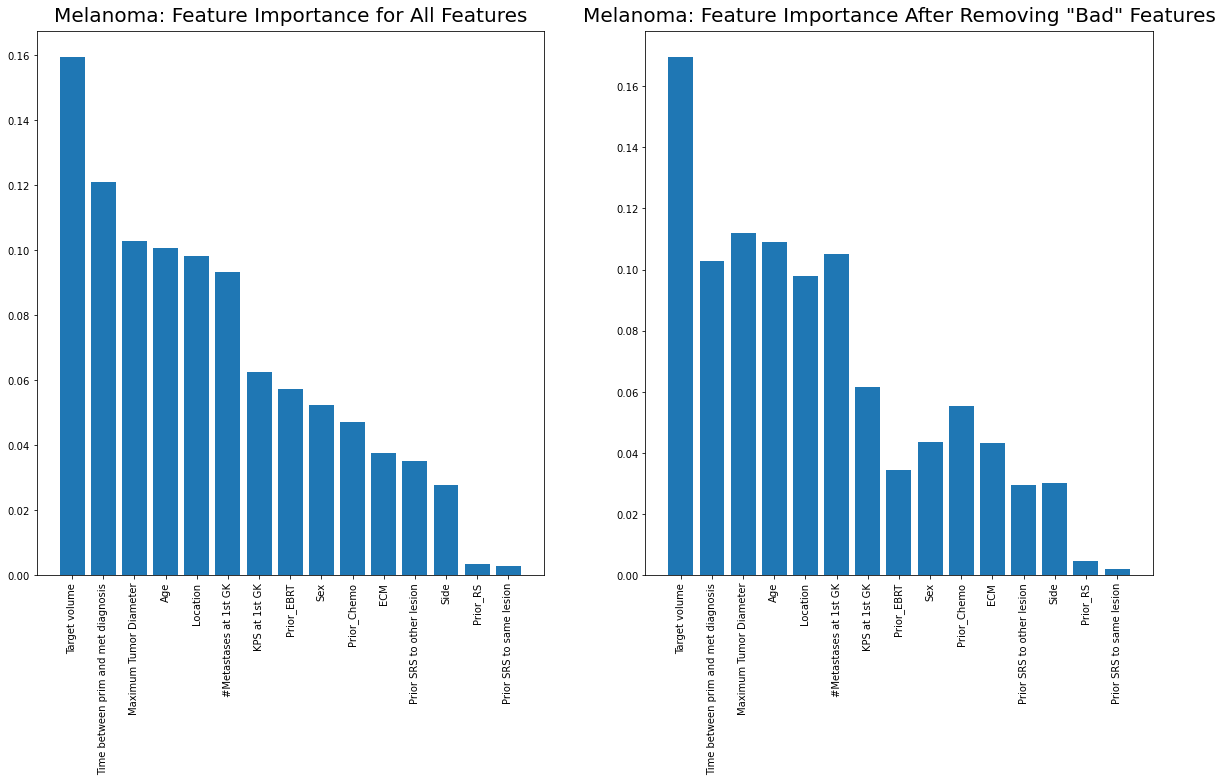

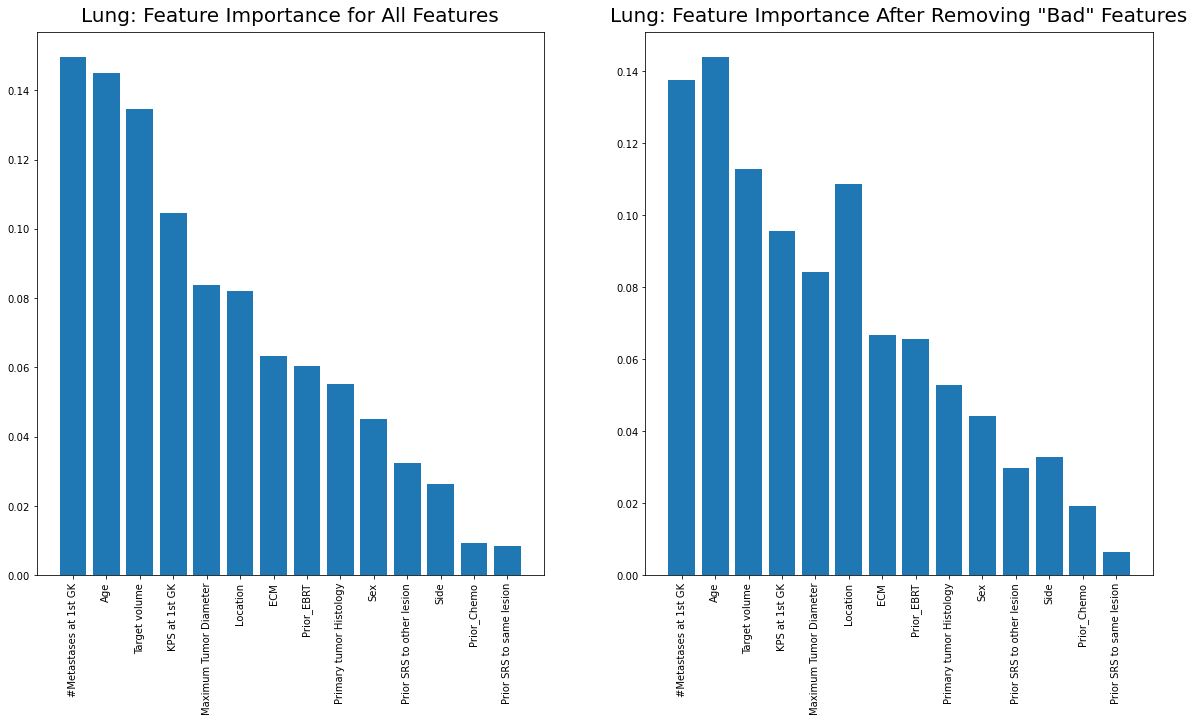

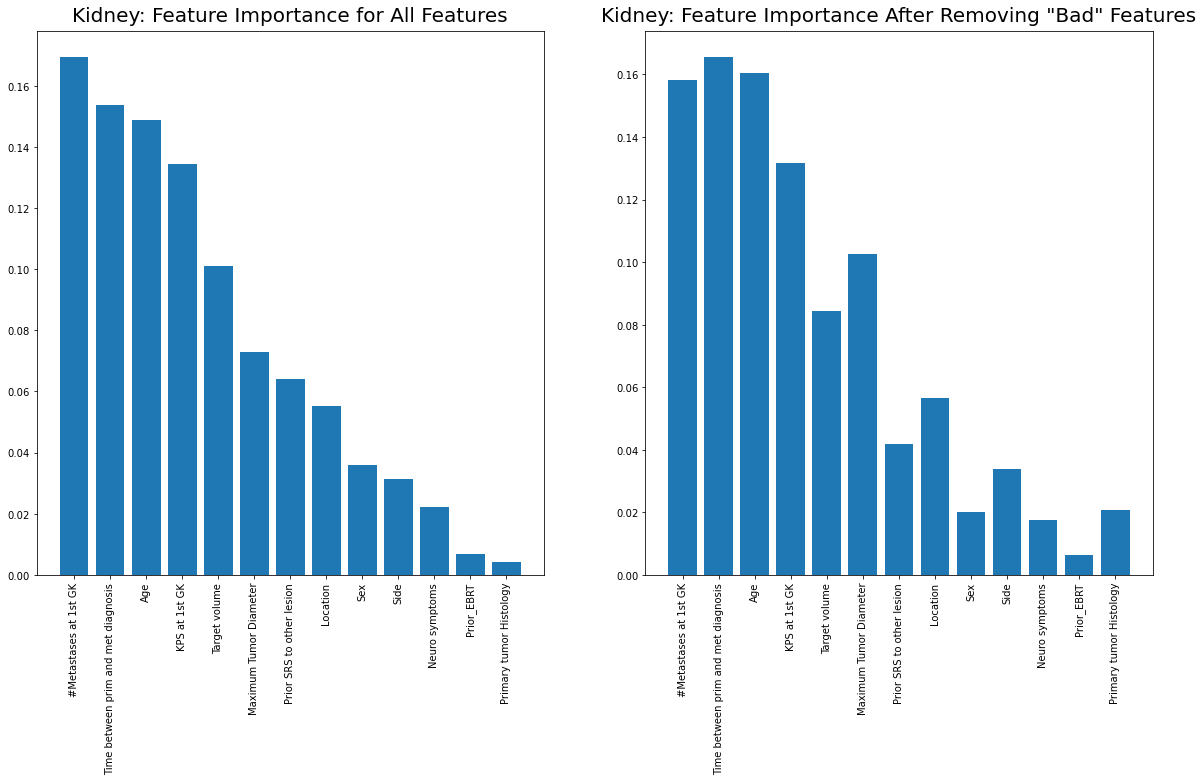

In [72]:
for site,output,X,y in info:
    h1,h2,h3,rf_all = output
    
    print('####',site+':')
    print('X_shape: \t',X.shape)
    print("min_samples_leaf %d, max_features %.1f, max_depth %d" % (h1,h2,h3))

    imp = rf_all.feature_importances_
    imp_dic = {}
    for i,col in enumerate(X.columns):
        imp_dic[col]=imp[i]


    threshold = 0.001
    good_fea = {}
    print('Remove "bad feature":')
    for k,v in imp_dic.items():
        if v<threshold:
            print(f'\t{k}:  {v:.4f}')
        else:
            good_fea[k]=v
    good_fea = dict(sorted(good_fea.items(),key = lambda x:x[1],reverse=True))
    X_g= X[good_fea.keys()]
    rf_g = RandomForestRegressor(n_jobs = -1, 
                                   n_estimators=100, 
                                   min_samples_leaf=h1,
                                   max_features=h2, 
                                   max_depth=h3, 
                                   verbose=0,
                                   oob_score=True)
    rf_g.fit(X_g,y)
    print(f'The out of bag R2 score for model with all features is \t {rf_all.oob_score_:.3f}.')
    print(f'The out of bag R2 score for model removing "bad features" is  \t {rf_g.oob_score_:.3f}.')
    print()
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))

    feature_importance_visual(ax1,good_fea.keys(),good_fea.values(),f'{site}: Feature Importance for All Features')
    feature_importance_visual(ax2,X_g.columns,rf_g.feature_importances_,f'{site}: Feature Importance After Removing "Bad" Features')
    #    feature_importance_visual(col,rf_a[3])

    # print(f'The R2 score for NO CV search is {rf_no_cv[-2]:.3f} and MSE is {rf_no_cv[-1]:.3f}.')
    # print("min_samples_leaf %d, max_features %.1f, max_depth %d" % (rf_no_cv[0],rf_no_cv[1],rf_no_cv[2]))
    # feature_importance_visual(col,rf_no_cv[3])
    